In [104]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:6720]
    zero_padding = tf.zeros([6720] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

def to_spectrogram(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([6720] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [105]:
POS = os.path.join('data', 'pos')
NEG = os.path.join('data', 'neg')
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [106]:
for i in pos.as_numpy_iterator():
    print(i)

b'data\\pos\\ptk-2_20.wav'
b'data\\pos\\ptk-2_19.wav'
b'data\\pos\\ptk-2_21.wav'
b'data\\pos\\ptk-2_07.wav'


In [107]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [108]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [109]:
for i in positives.as_numpy_iterator():
    print(i)

(b'data\\pos\\ptk-2_19.wav', 1.0)
(b'data\\pos\\ptk-2_21.wav', 1.0)
(b'data\\pos\\ptk-2_07.wav', 1.0)
(b'data\\pos\\ptk-2_20.wav', 1.0)


In [110]:
for i in negatives.as_numpy_iterator():
    print(i)

(b'data\\neg\\ptk-2_14.wav', 0.0)
(b'data\\neg\\ptk-2_17.wav', 0.0)
(b'data\\neg\\ptk-2_15.wav', 0.0)
(b'data\\neg\\ptk-2_18.wav', 0.0)


In [111]:
data.as_numpy_iterator().next()[0].shape

AttributeError: 'bytes' object has no attribute 'shape'

In [112]:
# file_contents = tf.io.read_file(b'data\\pos\\ptk-2_07.wav')

In [113]:
lengths = []
for file in os.listdir(os.path.join('data', 'pos')):
    tensor_wave = load_wav_16k_mono(file)
    lengths.append(len(tensor_wave))

In [114]:
lengths

[6720, 6720, 6720, 6720]

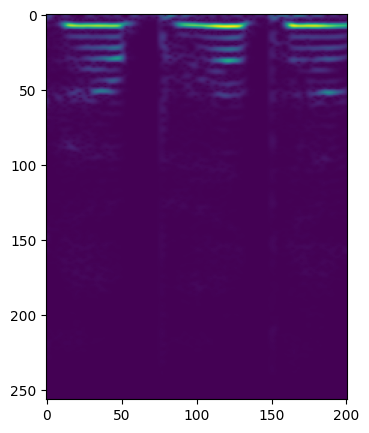

In [115]:
filepath, label = positives.as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(5,5))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [116]:
spectrogram

<tf.Tensor: shape=(201, 257, 1), dtype=float32, numpy=
array([[[1.59384340e-01],
        [1.80412084e-01],
        [1.96838886e-01],
        ...,
        [1.78891405e-05],
        [5.69111717e-06],
        [1.63912773e-07]],

       [[2.20029771e-01],
        [2.22208381e-01],
        [2.04420060e-01],
        ...,
        [1.33774856e-05],
        [5.66463677e-06],
        [1.51991844e-06]],

       [[2.38749161e-01],
        [2.25397974e-01],
        [1.82465270e-01],
        ...,
        [1.06886864e-05],
        [3.83207635e-06],
        [3.38256359e-06]],

       ...,

       [[1.00029424e-01],
        [8.27607214e-02],
        [5.47639318e-02],
        ...,
        [1.26402813e-06],
        [9.75001740e-07],
        [1.35973096e-06]],

       [[9.34064239e-02],
        [8.52593035e-02],
        [5.00419810e-02],
        ...,
        [1.10361100e-06],
        [7.52997778e-07],
        [7.59959221e-07]],

       [[8.98878202e-02],
        [6.95402846e-02],
        [3.51463109e-02],

In [117]:
spectrogram.shape

TensorShape([201, 257, 1])

In [118]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=2)
data = data.batch(5)
data = data.prefetch(5)

In [119]:
data

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [140]:
# train = data.take(8)
# # test = data.take(4)
# test = train
train = data.take(6)
test = data.take(2)

In [141]:
samples, labels = test.as_numpy_iterator().next()
samples.shape

(5, 201, 257, 1)

In [142]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [143]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(201, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [127]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [128]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 199, 255, 16)      160       
                                                                 
 conv2d_5 (Conv2D)           (None, 197, 253, 16)      2320      
                                                                 
 flatten_2 (Flatten)         (None, 797456)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               102074496 
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 102,077,105
Trainable params: 102,077,105
Non-trainable params: 0
_________________________________________________________________


In [129]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
2/2 [==============================] - 2s 612ms/step - loss: 2.5668 - recall_2: 0.7500 - precision_2: 0.4286 - val_loss: 0.5963 - val_recall_2: 1.0000 - val_precision_2: 0.5000
Epoch 2/4
2/2 [==============================] - 1s 356ms/step - loss: 0.3011 - recall_2: 1.0000 - precision_2: 0.8000 - val_loss: 1.0078 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 3/4
2/2 [==============================] - 1s 427ms/step - loss: 1.0301 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - val_loss: 0.6944 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 4/4
2/2 [==============================] - 1s 439ms/step - loss: 0.7126 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - val_loss: 0.4719 - val_recall_2: 0.5000 - val_precision_2: 1.0000


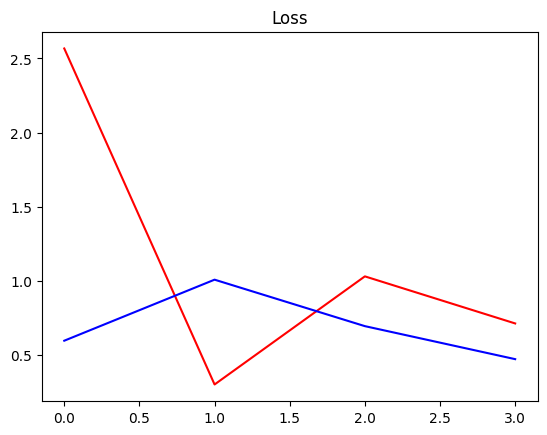

In [130]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

KeyError: 'precision'

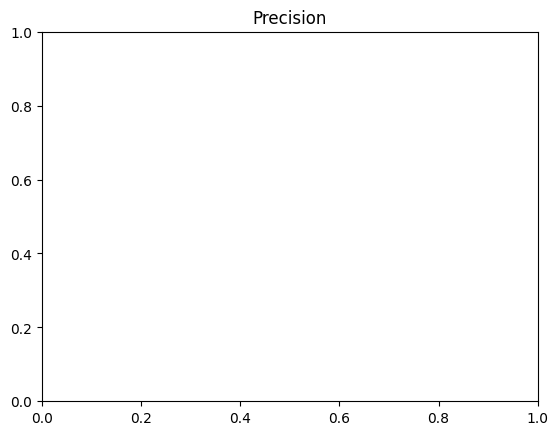

In [131]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

KeyError: 'recall'

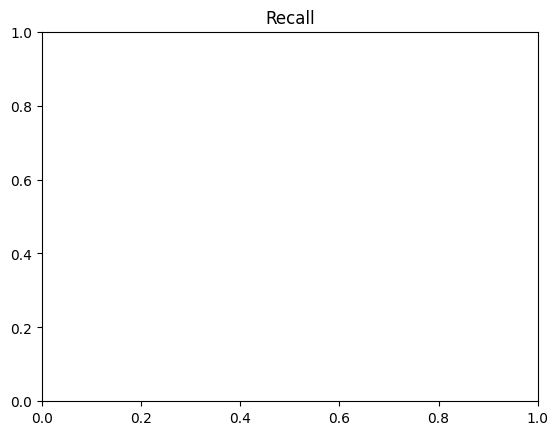

In [132]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [133]:
X_test, y_test = test.as_numpy_iterator().next()

In [134]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 69ms/step


In [135]:
[prediction for prediction in yhat]

[array([0.71837515], dtype=float32),
 array([0.6016154], dtype=float32),
 array([0.39536718], dtype=float32),
 array([0.47406903], dtype=float32),
 array([0.31180918], dtype=float32)]

In [136]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [137]:
yhat

[1, 1, 0, 0, 0]

# Cut long audio

In [98]:
# wav_long = load_wav_16k_mono("ptk-2_12.wav")
wav_long = load_wav_16k_mono(b'ptk_2.wav')
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav_long, wav_long, sequence_length=2240, sequence_stride=2240, batch_size=1)
# audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav_long, wav_long, sequence_length=6720, sequence_stride=2240, batch_size=1)

In [99]:
audio_slices = audio_slices.map(to_spectrogram)
audio_slices

<MapDataset element_spec=TensorSpec(shape=(None, 257, 1), dtype=tf.float32, name=None)>

In [100]:
audio_slices = audio_slices.batch(64)
audio_slices

<BatchDataset element_spec=TensorSpec(shape=(None, None, 257, 1), dtype=tf.float32, name=None)>

In [101]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

2/2 [==============================] - 0s 124ms/step


In [102]:
len(yhat)

104

In [103]:
count = 0
for i in range(len(yhat)):
    if i >= 2:
        if yhat[i-2] != 1 and yhat[i] == 1:
            count = count + 1
    elif i == 1:
        if yhat[0] != 1 and yhat[i] == 1:
            count = count + 1
    elif i == 0:
        if yhat[i] == 1:
            count = count + 1
count

16

In [155]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(201, 257, 1), pooling='avg')
x = model.output
output = Dense(units=1, activation='softmax')(x)
model = Model(inputs=model.input, outputs=output)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

ValueError: The input must have 3 channels; Received `input_shape=(201, 257, 1)`

In [148]:
h2 = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


ValueError: in user code:

    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\User\anaconda3\envs\temp02\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 10) are incompatible
